In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
PATH = './p1_data/'
train_set_name = [str(i) + "_" + str(j) + ".png" for i in range(1, 41) for j in range(1, 10)]
test_set_name = [str(i) + "_10" + ".png" for i in range(1, 41)]

train_x = [cv2.imread(PATH + train_data, cv2.IMREAD_GRAYSCALE) for train_data in train_set_name]
train_x = np.array(train_x).reshape(360, -1)  # (360, 2576)
train_y = [i for i in range(1, 41) for _ in range(1, 10)]
train_y = np.array(train_y)  # (360)

test_x = [cv2.imread(PATH + test_data, cv2.IMREAD_GRAYSCALE) for test_data in test_set_name]
test_x = np.array(test_x).reshape(40, -1)  # (40, 2576)
test_y = [i for i in range(1, 41)]
test_y = np.array(test_y)  # (40)


In [6]:
sample = cv2.imread(PATH + "1_1.png", cv2.IMREAD_GRAYSCALE)
print("Size of training set:", len(train_x))
print("Size of testing set:", len(test_x))
print("Image shape:", sample.shape)
print("Image vector size:", train_x[0].shape)

Size of training set: 360
Size of testing set: 40
Image shape: (56, 46)
Image vector size: (2576,)


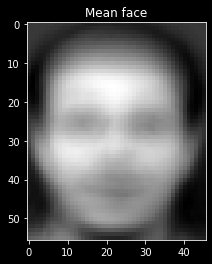

In [13]:
# Plot the mean face
mean_face_vec = train_x.mean(axis=0)
plt.imshow(mean_face_vec.reshape(56,46), cmap='gray')
plt.title("Mean face")
plt.show()

PCA output shape: (359, 2576)


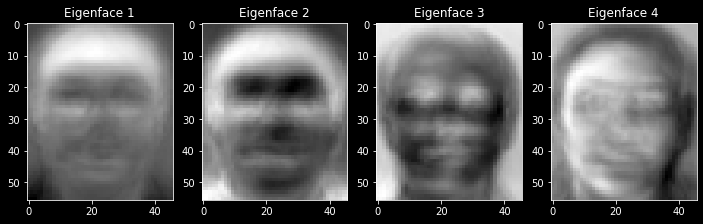

In [16]:
# Perform PCA
N = train_x.shape[0]
pca = PCA(n_components = N-1)  # only need to preserve the first N-1 eigenvectors
output = pca.fit(train_x - mean_face_vec)
print("PCA output shape:", output.components_.shape)

# Plot the first four eigenfaces
eigenface_1 = (output.components_[0]).reshape(56,46)  # reshape the eigenvector to become the eigenface
eigenface_2 = (output.components_[1]).reshape(56,46)
eigenface_3 = (output.components_[2]).reshape(56,46)
eigenface_4 = (output.components_[3]).reshape(56,46)

plt.figure(figsize=(12,6))
plt.subplot(141)
plt.imshow(eigenface_1, cmap='gray')
plt.title("Eigenface 1")
plt.subplot(142)
plt.imshow(eigenface_2, cmap='gray')
plt.title("Eigenface 2")
plt.subplot(143)
plt.imshow(eigenface_3, cmap='gray')
plt.title("Eigenface 3")
plt.subplot(144)
plt.imshow(eigenface_4, cmap='gray')
plt.title("Eigenface 4")
plt.show()

Reduced dimension: 359


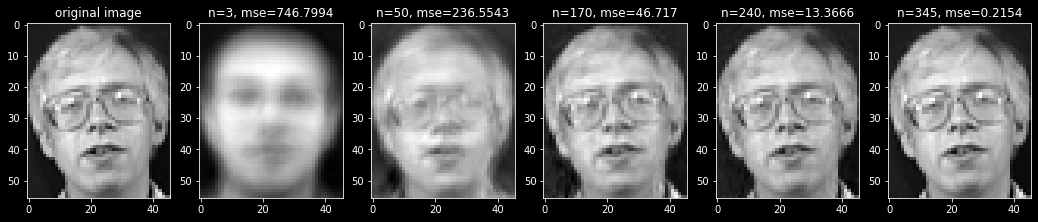

In [35]:
img = cv2.imread(PATH + "2_1.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(18,6))
plt.subplot(1, 6, 1)
plt.title("original image")
plt.imshow(img.reshape(56,46), cmap='gray')

img_vec = img.reshape(1, -1)
# project the image onto the eigenspace which has the N-1 eigenvector basis,
img_reduced = pca.transform(img_vec - mean_face_vec)  # dimension reduction image
print("Reduced dimension:", img_reduced.shape[1])

n_list = [3, 50, 170, 240, 345]  # the number of dimension we want to keep
for j, i in enumerate(n_list):
    img_recon = np.dot(img_reduced[0, :i], output.components_[:i]) + mean_face_vec
    mse = np.mean((img_recon - img_vec)**2)
    plt.subplot(1, 6, j+2)
    title = "n=" + str(i) + ", mse=" + str(np.round(mse, 4))
    plt.title(title)
    plt.imshow(img_recon.reshape(56,46), cmap = "gray")
plt.show()

In [49]:
# train the K-NN algorithm with the training set images
train_x_reduced = pca.transform(train_x - mean_face_vec)  # dimension reduction training set images
knn = KNeighborsClassifier()
param_k = {"n_neighbors":[1, 3, 5]}
clf = GridSearchCV(knn, param_k, cv=3) # 3-fold cross validation
 
n_list = [3, 50, 170]
print(".     k=1         k=3         k=5")
for i in n_list:
    clf.fit(train_x_reduced[:,:i], train_y)
    res = np.array(clf.cv_results_['mean_test_score'])
    print("n=%3d"%i, res) 
    

.     k=1         k=3         k=5
n=  3 [0.65       0.61111111 0.56111111]
n= 50 [0.96111111 0.9        0.84722222]
n=170 [0.95555556 0.88888889 0.82222222]


In [37]:
# The best choices for hyperparameters
k = 1
n = 50

In [38]:
# apply the K-NN algorithm to classify the testing set images.
test_x_reduced = pca.transform(test_x - mean_face_vec)  # dimension reduction testing set images
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_x_reduced[:,:n], train_y)
pred_y = knn.predict(test_x_reduced[:,:n])

acc = accuracy_score(y_pred=pred_y, y_true=test_y)
print("Accuracy of testing set:", acc)

Accuracy of testing set: 0.925
